In [22]:
import pandas as pd

amazon_df = pd.read_csv("amz_uk_price_prediction_dataset.csv")
display(amazon_df)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


In [23]:
#checking once again the columns
amazon_df.columns

Index(['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')

In [24]:
#verifying if there are null values 
amazon_df.isnull().sum()

uid                  0
asin                 0
title                0
stars                0
reviews              0
price                0
isBestSeller         0
boughtInLastMonth    0
category             0
dtype: int64

Part 1: Analyzing Best-Seller Trends Across Product Categories


Crosstab Analysis:



In [25]:
#Create a crosstab between the product category and the isBestSeller status.
crosstab_result = pd.crosstab(amazon_df['category'], amazon_df['isBestSeller'])

crosstab_result


isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


Are there categories where being a best-seller is more prevalent?



In [26]:
bestseller_proportion = (amazon_df.groupby("category")["isBestSeller"].mean())


In [27]:
bestseller_proportion_sorted = bestseller_proportion.sort_values(ascending=False)
bestseller_proportion_sorted


category
Grocery                           0.058135
Smart Home Security & Lighting    0.057692
Health & Personal Care            0.057686
Mobile Phone Accessories          0.042471
Power & Hand Tools                0.035339
                                    ...   
Bedding Collections               0.000000
CPUs                              0.000000
CD, Disc & Tape Players           0.000000
Blank Media Cases & Wallets       0.000000
eBook Readers & Accessories       0.000000
Name: isBestSeller, Length: 296, dtype: float64

Prevalence varies by category. Some categories, like 'Grocery', 'Smart Home Security & Lighting', 'Health & Personal Care' have  aprox. 5–6% of items labeled as best-sellers. Others have none (0%).


Statistical Tests:



In [28]:
#Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
from scipy.stats import chi2_contingency


chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

chi2_statistic, chi2_p_value

(np.float64(36540.20270061387), np.float64(0.0))

Since the p-value is effectively zero (p < 0.05), the null hypothesis is rejected. This indicates that best-seller distribution is not independent of product category.

In [29]:
#Compute Cramér's V to understand the strength of association between best-seller status and category.
from scipy.stats.contingency import association

# Computing the association between variables in 'crosstab_result' using the "cramer" method
association(crosstab_result, method="cramer")

0.1222829439760564

Cramér’s V = 0.122 indicates a small to moderate association between product category and best-seller status. This means that although best-seller status varies significantly across categories (as shown by the Chi-square test), the effect of category on best-seller likelihood is relatively small.

Visualizations

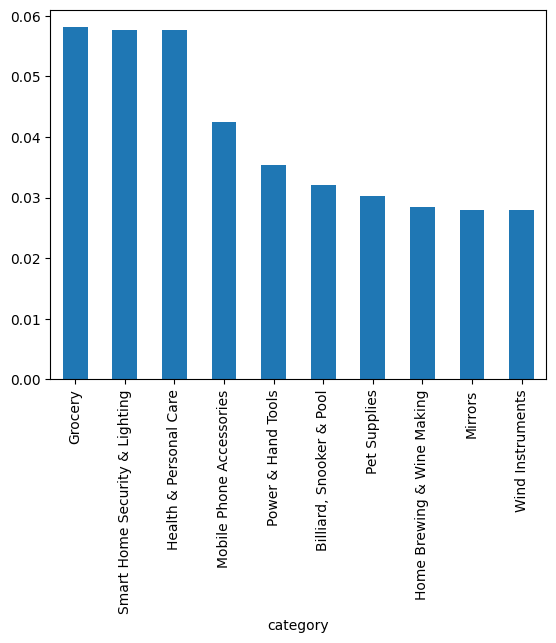

In [30]:
#Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

bestseller_proportion_sorted.head(10).plot(kind="bar", stacked=True);

Part 2: Exploring Product Prices and Ratings Across Categories and Brands


Preliminary Step: Remove outliers in product prices.



In [31]:
amazon_df_original = amazon_df.copy()


In [32]:
Q1 = amazon_df['price'].quantile(0.25)
Q3 = amazon_df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

amazon_df_no_outliers = amazon_df[(amazon_df['price'] >= lower_bound) & (amazon_df['price'] <= upper_bound)]


In [33]:
amazon_df_no_outliers

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


Violin Plots:



C:\Users\Alexandra\AppData\Local\Temp\ipykernel_12872\3977709102.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=amazon_df_top20,x='price',y='category',palette="coolwarm")


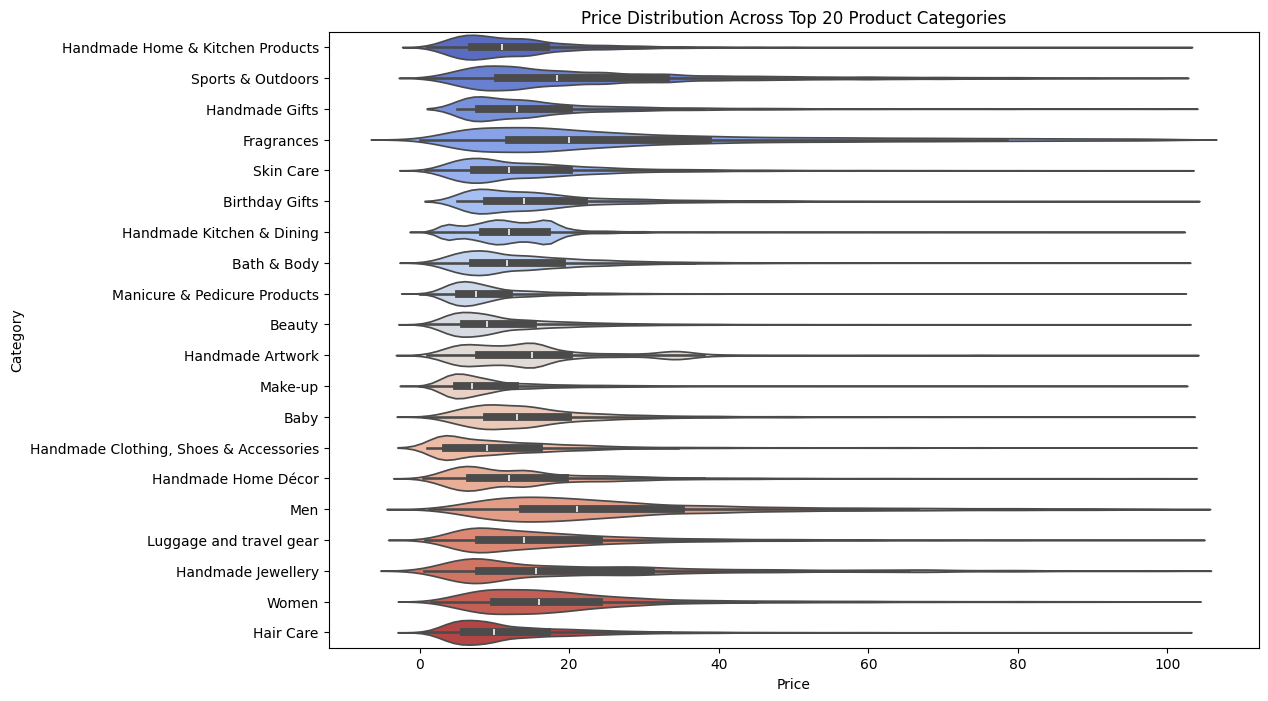

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Top 20 categories by count
top_categories = amazon_df_no_outliers['category'].value_counts().head(20).index

# Filter the DataFrame to only include these categories
amazon_df_top20 = amazon_df_no_outliers[amazon_df_no_outliers['category'].isin(top_categories)]

# Create the violin plot
plt.figure(figsize=(12,8))
sns.violinplot(data=amazon_df_top20,x='price',y='category',palette="coolwarm")

plt.title("Price Distribution Across Top 20 Product Categories")
plt.xlabel("Price")
plt.ylabel("Category")
plt.show()


Which product category tends to have the highest median price?

The Sports & Outdoors appears to command the highest average price among the categories shown.

Box Plots:



C:\Users\Alexandra\AppData\Local\Temp\ipykernel_12872\2336075073.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=amazon_df_top10, x='stars', y='category', palette="coolwarm", legend=False);


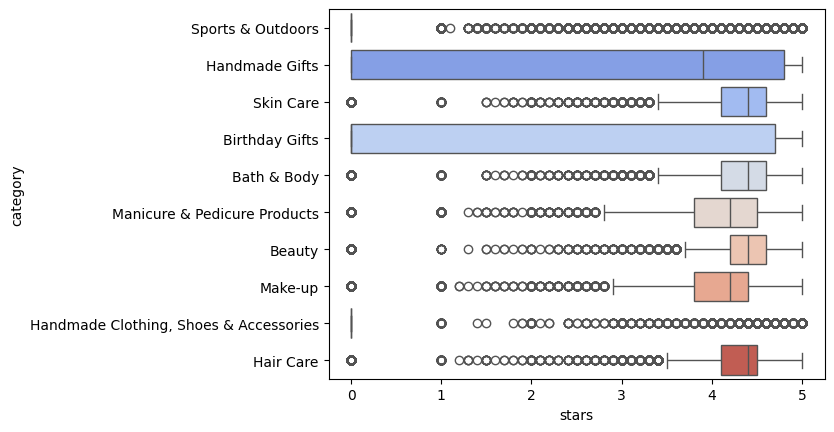

In [45]:
#Visualize the distribution of product ratings based on their category using side-by-side box plots. 

# Top 10 categories by count
top_categories_10 = amazon_df_no_outliers['category'].value_counts().head(10).index

# Filter the DataFrame to only include these categories
amazon_df_top10 = amazon_df_no_outliers[amazon_df_no_outliers['category'].isin(top_categories_10)]
sns.boxplot(data=amazon_df_top10, x='stars', y='category', palette="coolwarm", legend=False);

In [46]:
amazon_df_top10.groupby('category')['stars'].median()

category
Bath & Body                               4.4
Beauty                                    4.4
Birthday Gifts                            0.0
Hair Care                                 4.4
Handmade Clothing, Shoes & Accessories    0.0
Handmade Gifts                            3.9
Make-up                                   4.2
Manicure & Pedicure Products              4.2
Skin Care                                 4.4
Sports & Outdoors                         0.0
Name: stars, dtype: float64

Which category tends to receive the highest median rating from customers?
The categories with the highest median rating, as 4.4, are 'Bath and Body', 'Beauty', 'Hair Care', 'Skin Care'.

Part 3: Investigating the Interplay Between Product Prices and Ratings


Correlation Coefficients:



In [36]:
#Calculate the correlation coefficient between price and stars.
correlation = amazon_df_no_outliers['price'].corr(amazon_df_no_outliers['stars'])
correlation

np.float64(-0.07767299878181444)

Is there a significant correlation between product price and its rating?

No, the result *np.float64(-0.07767299878181444)* is very small, pratically 0.



Visualizations

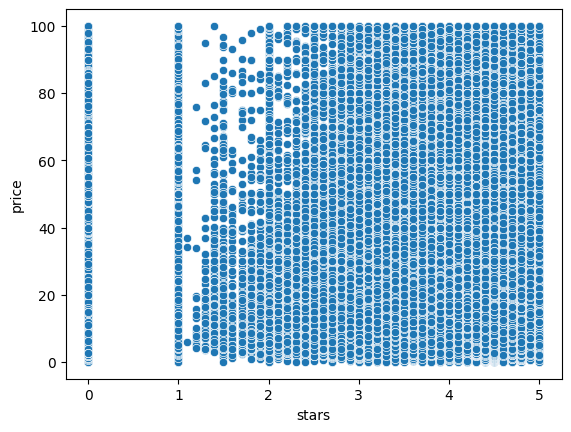

In [37]:
#Use a scatter plot to visualize the relationship between product rating and price.

sns.scatterplot(data=amazon_df_no_outliers, x='stars', y='price');

What patterns can you observe?

Most ratings are concentrated between 3 and 5 stars, indicating generally positive customer experiences. There are a few outliers in the 1–2 star range, along with a noticeable cluster at 0–1 star. The zero-star ratings may reflect customers who did not leave a review, while the one-star ratings likely represent dissatisfied buyers. Overall, the distribution suggests that although a small portion of customers were unhappy or did not provide feedback, the majority of customers were satisfied with their purchases.

In [38]:
#Use a correlation heatmap to visualize correlations between all numerical variables.
amazon_df_no_outliers.dtypes

uid                    int64
asin                  object
title                 object
stars                float64
reviews                int64
price                float64
isBestSeller            bool
boughtInLastMonth      int64
category              object
dtype: object

In [39]:
amazon_df_no_outliers.columns

Index(['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')

In [40]:
numerical_variables = amazon_df_no_outliers[['stars','reviews','price','boughtInLastMonth']]

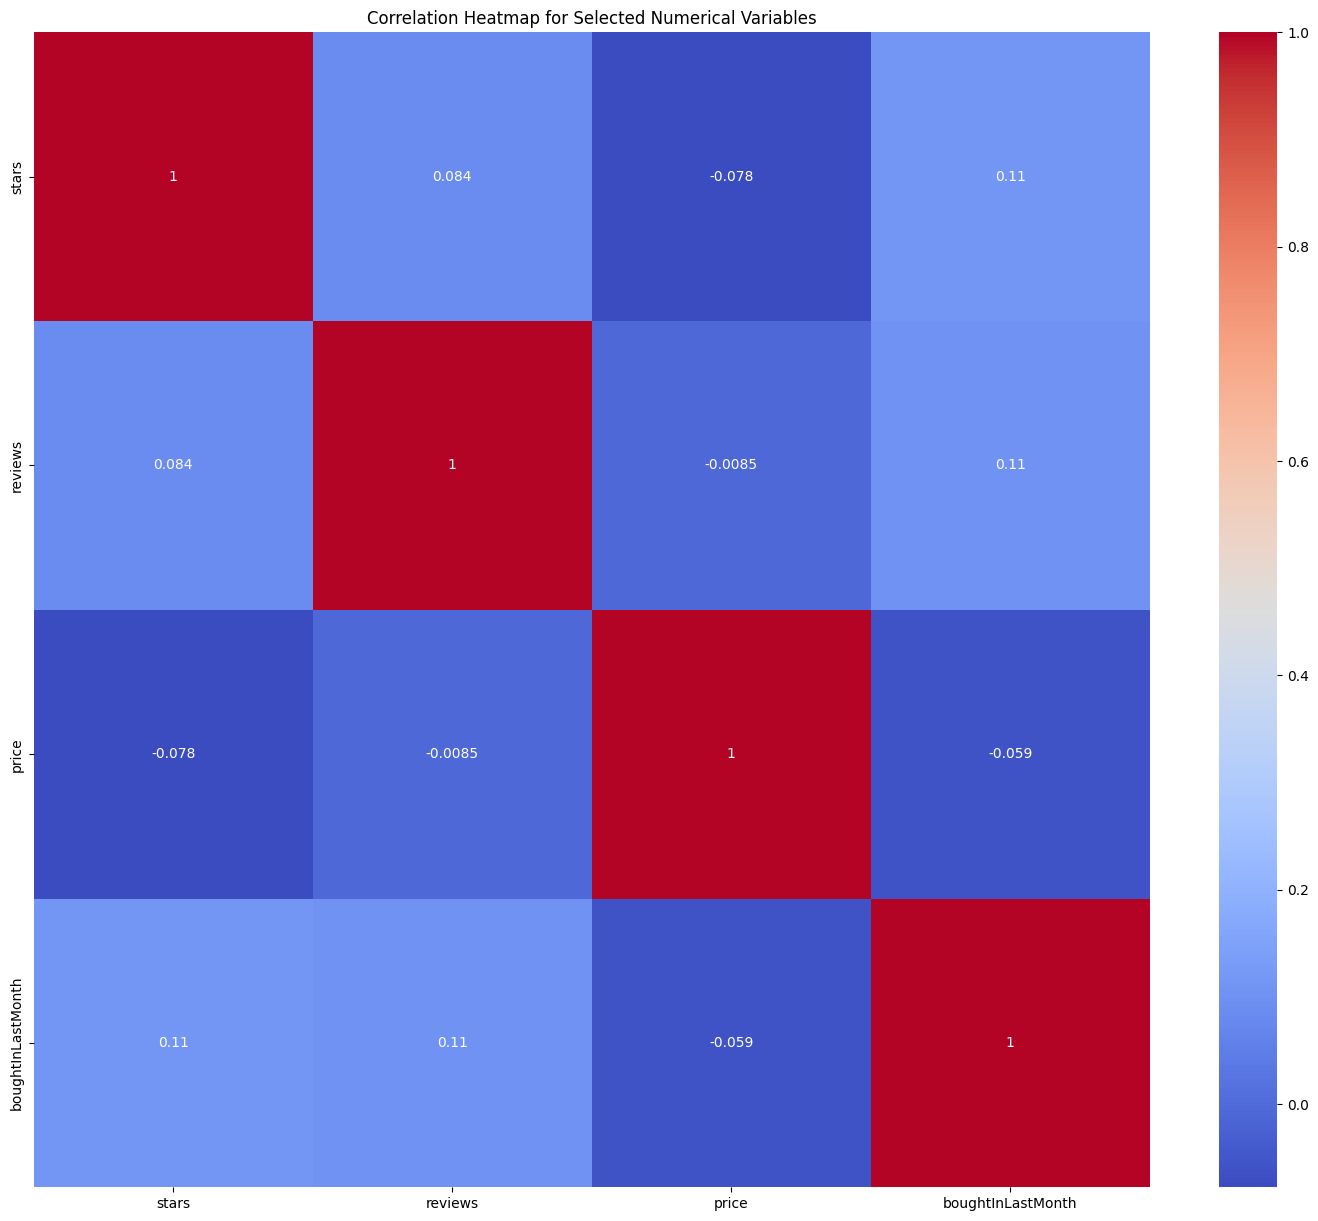

In [41]:
correlation_matrix = numerical_variables.corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(18, 15))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

Some variables, like `stars` and `reviews`, have a strong correlation with each other, as the people who are reviewing the products from 'boughtInLastMonth' are also the ones who are offering the stars. 

Examine if product prices typically follow a normal distribution using a QQ plot.


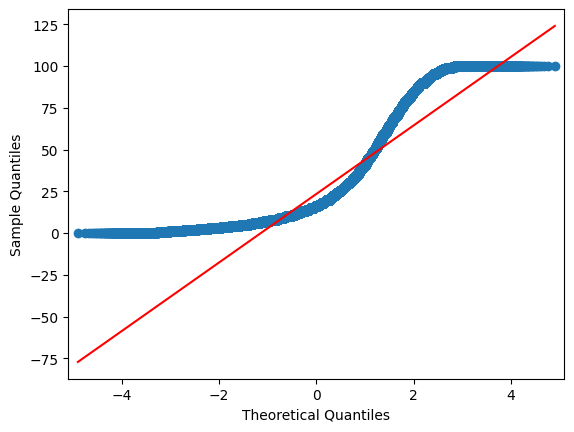

In [43]:
import statsmodels.api as sm
sm.qqplot(amazon_df_no_outliers['price'], line='s');

The product prices don't follow a normal distribution, because as we can see in the Q-Q plot, the sample quantiles does not match with the theoretical quantiles of a normal distribution. 
